![](images/2022-12-02-pytorch-word2vec-embedding.png)

## Credits
This notebook takes inspiration and ideas from the following sources.

* An excellent word2vec introduction from "Jay Alammar": [illustrated-word2vec](https://jalammar.github.io/illustrated-word2vec/). 
* Blog post by "Musashi (sometimes Jacobs-) Harukawa" with the same title. You can find the original post here: [word2vec-from-scratch](https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html). Parts of the code you see in this notebook are taken from this post.
* Another very detailed and well-explained blog post by "Olga Chernytska". You can find the original post here: [word2vec-with-pytorch-implementing-original-paper](https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0). Parts of the code you see in this notebook are taken from this post.

## Environment
This notebook [GitHub link here](https://github.com/hassaanbinaslam/myblog/blob/main/posts/2022-12-02-pytorch-word2vec-embedding.ipynb) is prepared with Google Colab. [Hugging Face Datasets](https://huggingface.co/docs/datasets/index) library is required for this post.

In [ ]:
# install hugging face datasets
! pip install datasets

In [2]:
#| code-fold: true
from platform import python_version
import numpy, matplotlib, pandas, torch, datasets

print("python==" + python_version())
print("numpy==" + numpy.__version__)
print("torch==" + torch.__version__)
print("matplotlib==" + matplotlib.__version__)
print("datasets==" + datasets.__version__)

python==3.8.15
numpy==1.21.6
torch==1.12.1+cu113
matplotlib==3.2.2
datasets==2.7.1


## Introduction
> Following are the `word2vec` and `word embedding` explanations provided by [OpenAI ChatGPT](https://chat.openai.com/chat). If unsatisfied, I suggest using the links provided in the "Credits" section ([illustrated-word2vec](https://jalammar.github.io/illustrated-word2vec/) from Jay Alammar). 

`prompt > word2vec blog introduction`

**Word2vec**

Word2vec is a widely-used natural language processing (NLP) algorithm that uses deep learning to learn the relationships between words in a corpus (a large collection of text data). A team of researchers developed it at Google, led by Tomas Mikolov in 2013.

Word2vec uses a neural network to learn the relationships between words by training on a large corpus of text data. The algorithm uses a shallow neural network with a single hidden layer to predict the surrounding words of a given word based on its context. The network's hidden layer is trained to capture the relationships between words, and the resulting vectors (or "word embeddings") can be used to represent the words in the corpus in a lower-dimensional space.

The benefits of using word2vec include the ability to capture the relationships between words in a corpus and the ability to handle large amounts of data efficiently. This makes it a useful tool for many NLP tasks, such as text classification, language translation and named entity recognition.

Overall, word2vec is a powerful and effective algorithm for learning the relationships between words in a corpus and has become a cornerstone of modern NLP techniques.

`prompt > word embedding short description`

**Word Embedding**

A word embedding represents a word in a low-dimensional, continuous vector space. This representation captures the semantic relationships between words in a corpus, allowing for more accurate and efficient natural language processing. Word embeddings are typically learned using neural network models, such as the word2vec algorithm. These learned embeddings can then be used in various NLP tasks, such as text classification and language translation.

**Summary of the steps followed in this notebook**

* Download hugging face [tweets_hate_speech_detection](https://huggingface.co/datasets/tweets_hate_speech_detection) dataset
* Preprocess the data to remove special characters and normalize the text
* Create tokens from the text and their vocabulary, and finally encode the tokens
* Create training dataset, model configuration, loss, and optimizer
* Train the model and extract the embedding layer weights
* Analyse the word embeddings learned from the tweets

## Data Preparation

### Load Hugging Face Dataset
For this notebook, I will use Hugging Face [Twitter Hate Speech Dataset](https://huggingface.co/datasets/tweets_hate_speech_detection). It contains training data with approximately 32K tweets divided into two groups: `hate speech` and `not a hate speech`. This dataset is originally for classification tasks, but we may use it to learn word embeddings (or word contexts). This approach can also be used to identify inherent biases present in the data.

In [3]:
import datasets

dataset = datasets.load_dataset("tweets_hate_speech_detection")

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Let's check the downloaded object
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
})

It shows that we have only a training set, and each element from the set has a `label` and `tweet` text.

In [5]:
train_ds = dataset["train"]
train_ds.features

{'label': ClassLabel(names=['no-hate-speech', 'hate-speech'], id=None),
 'tweet': Value(dtype='string', id=None)}

Let's check what the raw data looks like.

In [6]:
# print a few labels
print("** labels **\n", train_ds["label"][:5])

# print a few tweet texts
print("\n** tweets **")
for t in train_ds["tweet"][:5]:
    print(t)

** labels **
 [0, 0, 0, 0, 0]

** tweets **
@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
bihday your majesty
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
factsguide: society now    #motivation


This raw data shows that the labels are encoded as `0` and `1` for `no-hate` and `hate` speech, respectively. Therefore, we can improve our view by putting labels and tweets in Pandas's DataFrame and analyzing them side by side.

In [7]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

train_ds.set_format(type="pandas")
df = train_ds[:]

# a function to convert label codes to string value
def label_int2str(row):
    return train_ds.features["label"].int2str(row)


df["label_name"] = df["label"].apply(label_int2str)
df.head(10)

,label,tweet,label_name
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,no-hate-speech
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,no-hate-speech
2,0,bihday your majesty,no-hate-speech
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,no-hate-speech
4,0,factsguide: society now #motivation,no-hate-speech
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,no-hate-speech
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,no-hate-speech
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,no-hate-speech
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,no-hate-speech
9,0,@user @user welcome here ! i'm it's so #gr8 !,no-hate-speech


All these tweets are labeled as `no-hate-speech`. Let's view some of the tweets from the other class.

In [8]:
df[df["label"]==1].head(10)

,label,tweet,label_name
13,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot,hate-speech
14,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins,hate-speech
17,1,retweet if you agree!,hate-speech
23,1,@user @user lumpy says i am a . prove it lumpy.,hate-speech
34,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia,hate-speech
56,1,@user lets fight against #love #peace,hate-speech
68,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness,hate-speech
77,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦",hate-speech
82,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy,hate-speech
111,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦,hate-speech


In [9]:
# reset dataset to its original format
train_ds.reset_format()

### Preprocess data

We can not use raw text directly to train a model because machines understand numbers and not alphabets. But to properly encode our text (convert it into numbers), we need to do some extra steps.

* tweets also contain special characters from emoticons or emojis. However, they do not help learn word embeddings. So we need to strip them from the text.
* split the tweet text into proper words. Even though we can use all the words from the tweet text, experience has shown that not all are useful in learning embeddings. Words that are commonly omitted are either uncommon or rare words, or stopwords (commonly used words)
* Create a dictionary or vocabulary to filter words and encode them. This vocabulary helps move between encoded (integer) and character (or string) representations of words.

For some of these preprocessing tasks, we will use [Natural Language Toolkit (NLTK library)](https://www.nltk.org/).

> NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries.

In [10]:
import nltk

nltk.download("stopwords")  # for filtering common words
nltk.download("wordnet")  # for lemmatization of words
nltk.download("omw-1.4")  # required for 'wordnet'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

I have created a helper function in the next cell to preprocess and split the tweet text into tokens.

In [11]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

sw = stopwords.words("english")
wl = WordNetLemmatizer()


def split_tokens(row):
    # step 1: lower the text
    t = row["tweet"].lower()
    # step 2: remove all other characters except alphabets, numbers, and a space
    t = re.sub(r"[^a-z 0-9]", "", t)
    # step 3: split the text into words or tokens. split is made at each "space" character
    t = re.split(r" +", t)
    # step 4: remove stop words
    t = [i for i in t if (i not in sw) and (i not in ["user"]) and len(i)]
    # step 5: lemmatize words
    t = [wl.lemmatize(i) for i in t]

    row["all_tokens"] = t
    return row

Let's use a sample tweet text to uncover the working of this function.

In [12]:
sample_tweet = train_ds[0]["tweet"]
sample_tweet

'@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

**Step 1: lower the text**

In [13]:
t = sample_tweet.lower()
t

'@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

**Step 2: remove all other characters except alphabets, numbers, and spaces**

In [14]:
t = re.sub(r"[^a-z 0-9]", "",t)
t

'user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run'

**Step 3: split the text into words or tokens. split is made at each "space" character**

In [15]:
t = re.split(r" +", t)
t

['user',
 'when',
 'a',
 'father',
 'is',
 'dysfunctional',
 'and',
 'is',
 'so',
 'selfish',
 'he',
 'drags',
 'his',
 'kids',
 'into',
 'his',
 'dysfunction',
 'run']

**Step 4: remove stop words**
Besides stop words, I have also filtered "user" from the text. This is because in the original tweet text, any reference to a Twitter user (e.g., @hassaanbinaslam) is replaced with `@user` to hide identity.

In [16]:
t = [i for i in t if (i not in sw) and (i not in ["user"]) and len(i)]
t

['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run']

English language stop words taken from the NLTK library include the following list.

In [17]:
# englist language stopwords from NLTK
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**Step 5: lemmatize words**
*What is lemmatization anyway?*
Lemmatization is applied to normalize the text. It considers the context and converts the word to its meaningful base form, which is called Lemma. to read more about it, refer to [what-is-the-difference-between-lemmatization-vs-stemming](https://stackoverflow.com/questions/1787110/what-is-the-difference-between-lemmatization-vs-stemming)

In [18]:
t = [wl.lemmatize(i) for i in t]
t

['father', 'dysfunctional', 'selfish', 'drag', 'kid', 'dysfunction', 'run']

Let's use the helper function `split_tokens` and compare our output.

In [19]:
split_tokens(train_ds[0])

{'label': 0,
 'tweet': '@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 'all_tokens': ['father',
  'dysfunctional',
  'selfish',
  'drag',
  'kid',
  'dysfunction',
  'run']}

Our preprocessing steps and tokenize function is ready. So let's apply it to our entire tweet dataset.

In [20]:
# tokenize tweet dataset
train_ds_all_tokens = train_ds.map(split_tokens)
train_ds_all_tokens

Dataset({
    features: ['label', 'tweet', 'all_tokens'],
    num_rows: 31962
})

### Create vocabulary
A vocabulary is a dictionary where each `key` represents the token (word ) string form. The `value` obtained from the dictionary defines the token's unique integer or encoded form. To create our vocabulary, we will follow the following approach.

1. Iterate through all the tweets (entire dataset) and count the frequency of all the tokens.
2. Remove the rare or uncommon tokens. This helps in reducing the size of the vocabulary. However, these uncommon tokens also include words created with typos e.g., while tweeting someone incorrectly typed `fahtr` instead of `father`. In our case, we will remove all tokens with a frequency of less than 10.
3. After that, we will put our filtered tokens in an ordered dictionary
4. Pass the ordered dictionary to Pytorch [Vocab class](https://pytorch.org/text/stable/vocab.html). A vocab object automatically maps tokens to indices.

In [21]:
# create a frequency map for all toekns
from collections import Counter

token_count = Counter()
for row_tokens in train_ds_all_tokens["all_tokens"]:
    token_count.update(row_tokens)

print("Number of tokens found: ", len(token_count))

Number of tokens found:  38988


In [22]:
# remove uncommon tokens
min_token_freq = 10
token_count_filtered = {k: v for k, v in token_count.items() if v > min_token_freq}

print("Number of tokens after filtering: ", len(token_count_filtered))

Number of tokens after filtering:  3007


Notice that by removing uncommon tokens, we have significantly reduced the size of our vocabulary (almost 13x less). In the next step, we will sort them, convert them to [OrdreredDict](https://realpython.com/python-ordereddict/), and pass them to `torchtext.vocab`.

In [23]:
from torchtext.vocab import vocab
from collections import OrderedDict

# sort the tokens based on their frequency
sorted_by_freq_tuples = sorted(
    token_count_filtered.items(), key=lambda x: x[1], reverse=True
)
# create a dictionary of tokens
ordered_dict = OrderedDict(sorted_by_freq_tuples)
# convert the dictionary into a vocabulary
vb = vocab(ordered_dict)

Using the following methods, we can use the vocabulary to move between the token's integer and string form.

* `vb['love']` to get the id '0' for token 'love'
* `vb.get_stoi()['love']` to get id '0' for token 'love'
* `vb.lookup_token('love')` to get id '0' for token 'love'
* `vb.lookup_tokens(['love', 'happy'])` to get id '0' and '2' for token 'love' and 'happy'
* `vb.get_itos()[0]` to get token 'love' from id '0'
* `vb.lookup_indices([0, 2])` to get token 'love' and 'happy' from id '0' and '2'

In [24]:
vb["love"], vb.get_stoi()["love"], vb.get_itos()[0]

(0, 0, 'love')

In [25]:
# let's check a few more tokens
for i in range(5):
    token = vb.get_itos()[i]
    print(f"{i} ---> {token}")
    print(f"{token} ---> {vb.get_stoi()[token]}")
    print()

0 ---> love
love ---> 0

1 ---> day
day ---> 1

2 ---> happy
happy ---> 2

3 ---> u
u ---> 3

4 ---> amp
amp ---> 4



Alright, we have our vocabulary ready. Remember that we have filtered our vocabulary to remove uncommon tokens. Let's use this vocabulary to do the same for our tweet text tokens.

In [26]:
# use vocabulary to filter uncommon tokens from tweets
def remove_rare_tokens(row):
    row["tokens"] = [t for t in row["all_tokens"] if t in vb]
    return row


train_ds_tokens = train_ds_all_tokens.map(remove_rare_tokens)

In the following cell output, note that only three tokens are left for a sample tweet after removing uncommon tokens.

In [27]:
# verify the dataset after filtering
train_ds_tokens[0]

{'label': 0,
 'tweet': '@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 'all_tokens': ['father',
  'dysfunctional',
  'selfish',
  'drag',
  'kid',
  'dysfunction',
  'run'],
 'tokens': ['father', 'kid', 'run']}

### Create training samples using skip-gram
The next step is to create training samples using a " skip-gram " technique. To understand it, let's take an example of a sample tweet text: `i get to see my daddy today!`. After applying preprocessing steps, the word tokens produced from the tweet are: `['get', 'see', 'daddy', 'today']`. The vocabulary indices (integer value) for these tokens are provided below.

| **Tokens** 	| **Indices** 	|
|:----------:	|:-----------:	|
|     get    	|      10     	|
|     see    	|      22     	|
|    daddy   	|     404     	|
|    today   	|      9      	|

For creating training samples using skip-gram, we take each token as an input and a surrounding token as the label. But we also need to decide the window size, meaning how many surrounding tokens to create training samples. Suppose we take `window_size=2`; then the training sample for this tweet will be.

| text    	|         	|           	|           	|      	| input 	| output 	|      	| input 	| output 	|
|---------	|---------	|-----------	|-----------	|------	|-------	|--------	|------	|-------	|--------	|
| **get** 	| see     	| daddy     	| today     	| ---> 	| get   	| see    	| ---> 	|    10 	|     22 	|
|         	|         	|           	|           	|      	| get   	| daddy  	|      	|    10 	|    404 	|
| get     	| **see** 	| daddy     	| today     	| ---> 	| see   	| get    	| ---> 	|    22 	|     10 	|
|         	|         	|           	|           	|      	| see   	| daddy  	|      	|    22 	|    404 	|
|         	|         	|           	|           	|      	| see   	| today  	|      	|    22 	|      9 	|
| get     	| see     	| **daddy** 	| today     	| ---> 	| daddy 	| get    	| ---> 	|   404 	|     10 	|
|         	|         	|           	|           	|      	| daddy 	| see    	|      	|   404 	|     22 	|
|         	|         	|           	|           	|      	| daddy 	| today  	|      	|   404 	|      9 	|
| get     	| see     	| daddy     	| **today** 	| ---> 	| today 	| see    	| ---> 	|     9 	|     22 	|
|         	|         	|           	|           	|      	| today 	| daddy  	|      	| 9     	| 404    	|

In the above table, we have generated ten training samples from 4 tokens with a window size of 2. In each sample, we have two tokens

* input or the training data
* output or the label value

Given the tokens and window size, let's create a function to create training samples for us.

In [28]:
# code source: https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html
def windowizer(row, wsize=3):
    # default 'window size' (wsize) is three
    doc = row["tokens"]
    wsize = wsize
    out = []
    for i, wd in enumerate(doc):
        target = vb[wd]
        window = [
            i + j
            for j in range(-wsize, wsize + 1, 1)
            if (i + j >= 0) & (i + j < len(doc)) & (j != 0)
        ]

        out += [(target, vb[doc[w]]) for w in window]
    row["moving_window"] = out
    return row


train_ds_tokens = train_ds_tokens.map(windowizer)

Let's check a sample tweet with generated training samples.

In [29]:
# note that we have used skip-gram window size=3
train_ds_tokens[12]

{'label': 0,
 'tweet': 'i get to see my daddy today!!   #80days #gettingfed',
 'all_tokens': ['get', 'see', 'daddy', 'today', '80days', 'gettingfed'],
 'tokens': ['get', 'see', 'daddy', 'today'],
 'moving_window': [[10, 22],
  [10, 404],
  [10, 9],
  [22, 10],
  [22, 404],
  [22, 9],
  [404, 10],
  [404, 22],
  [404, 9],
  [9, 10],
  [9, 22],
  [9, 404]]}

### Create dataset and dataloader
The preprocessing part of the data is complete. Now we only need to load this data into the Pytorch Dataset class and create batches for model training using DataLoader class. Both are utilities or helper classes provided by PyTorch to make our dataset (data preparation) code decoupled from our model training code for better readability and modularity. 

* `torch.utils.data.Dataset` stores the samples and their corresponding labels
* `torch.utils.data.DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

In [30]:
# source: https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html
# Helper class to make our data compatible with PyTorch Dataset
from torch.utils.data import Dataset

class Word2VecDataset(Dataset):
    def __init__(self, dataset, vocab_size):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset["moving_window"] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [31]:
vb_size = len(vb)

word2vec_ds = Word2VecDataset(train_ds_tokens, vocab_size=vb_size)

print(
    f"a word2vec_ds entry: {word2vec_ds[0]}",
    f"\nnumber of word2vec_ds entries: {len(word2vec_ds)}",
)

a word2vec_ds entry: [13, 123] 
number of word2vec_ds entries: 761044


`word2vec_ds` is our training dataset, and a single entry from it is of shape `(input, label)`. Notice that there are many entries (or training samples) in `word2vec_ds`, and these samples represent all of the tweets tokens. For training, we need to create batches from them for faster processing. So let's do that next.

In [32]:
from torch.utils.data import DataLoader

BATCH_SIZE = 2 ** 14
N_LOADER_PROCS = 10

dataloader = DataLoader(
    word2vec_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_LOADER_PROCS
)

print(f"number of training batches: {len(dataloader)}")

number of training batches: 47


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [33]:
tmp = next(iter(dataloader))
tmp

[tensor([  46, 1743,    0,  ...,   28,    8,  122]),
 tensor([  15, 2197,  197,  ...,  179,  846,    0])]

In the last cell, I fetched a single batch from the dataloader. Its output is two long tensors.

* The first tensor has all the entries for the input data
* The second tensor has all the entries for the labels

The size of both these tensors is the same.

## Model Configuration

Now we will configure the model to be used for training. 

**What are we trying to solve with our model?**

We are trying to train a model that can predict the surrounding words of a given input. And this is how we have designed our training data too. Each training sample has `(input, label)`. Where `input` is the given token, and `label` is some nearby token. It is like forcing the model to predict the context of an input word.

**How can such a model be helpful to us?**

Such a model that can predict the context of a word is not helpful to us in any actual scenario. So we are not going to use it. Instead, we are only interested in the learned weights of such a model, and we call them `word embedding`. It is like faking a problem (creating a pseudo-problem), training a model, and then using the learned weights for other tasks.

In [34]:
# source: https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html
import torch.nn as nn

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        # Encode input to lower-dimensional representation
        hidden = self.embed(input)
        # Expand hidden layer to predictions
        logits = self.expand(hidden)
        return logits

Notice that in the model configuration, the size of the output layer (nn.Linear) is equal to our vocabulary size. So, our model is configured for a multi-classification problem.

In [35]:
EMBED_SIZE = 100
model = Word2Vec(vb_size, EMBED_SIZE)

# Relevant if you have a GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

model.to(device)

cuda


Word2Vec(
  (embed): Embedding(3007, 100)
  (expand): Linear(in_features=100, out_features=3007, bias=False)
)

Now configure the loss function and a training optimizer.

In [36]:
import torch

LR = 3e-4  # learning rate
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

## Model Training
In this section we are going to train our model for 100 epochs. 

In [37]:
# source: https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html
from tqdm import tqdm  # For progress bar. https://github.com/tqdm/tqdm

EPOCHS = 100
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        center, context = center.to(device), context.to(device)

        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        progress_bar.update(1)
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)

100%|█████████▉| 4699/4700 [05:59<00:00, 40.21it/s]

Let's plot the training loss.

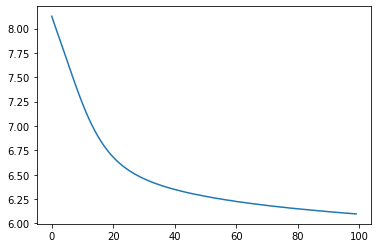

In [38]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

## Analyze Word Embeddings (Word Vectors)
Training is complete, and our model has learned something. In this section, we will analyze the learned weights and their quality.

So, let's extract the weights.

**We have weights in two layers: embedding and linear. Both have similar dimensions, so which should we use as embeddings?**
I have experimented with weights from both these layers, and here are some suggestions.

* Embeddings from the layer closer to the output layer give better results. In our case, it is the Linear layer. Our linear layer has the same dimensions as the embedding layer, and we will use weights from this layer.
* If the dimensions of the layers closer to the output layer are different than the Embedding layer, then we should stick to the embedding layer. Sometimes, people prefer to concatenate weights from multiple layers to create the final output.

In [39]:
# embedding = model.embed.weight.cpu().detach().numpy()
embedding = model.expand.weight.cpu().detach().numpy()
embedding.shape

(3007, 100)

Next, I have created some functions to calculate the distance between these word vectors. We are doing this to find a word similarity score with other words (cosine similarity). A smaller distance between two vectors means that these words are often used in similar contexts.

In [40]:
# source: https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(embedding, metric):
    dist_matrix = distance.squareform(distance.pdist(embedding, metric))
    return dist_matrix


def get_k_similar_words(word, dist_matrix, k=10):
    idx = vb[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[: k + 1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, vb.lookup_token(i), dists[i]) for i in ind]
    return out

In [41]:
# calculate 2d distance matrix
dmat = get_distance_matrix(embedding, "cosine")
dmat.shape

(3007, 3007)

Another helper function is to print similar words identified based on their distance.

In [42]:
def similar_words(tokens):
    for word in tokens:
        print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

Next, I selected some tokens and used embeddings to find words most similar to them.

In [43]:
tokens = ["father", "mother", "boy", "girl"]  # tokens for relations
tokens += ["job", "sad", "happy", "hate"]  # for emotions
tokens += ["america", "england", "india"]  # for regions
tokens += ["football", "swimming", "cycling"]  # for sports
tokens += ["exercise", "health", "fitness"]  # for health

similar_words(tokens)

father ['dad', 'fathersday', 'day', 'happy', 'love', 'one', 'bihday', 'kid', 'u', 'today'] 

mother ['care', 'child', 'son', 'died', 'father', 'kill', 'men', 'ten', 'born', 'wife'] 

boy ['girl', 'guy', 'man', 'smile', 'little', 'family', 'love', 'selfie', 'day', 'face'] 

girl ['smile', 'summer', 'love', 'guy', 'happy', 'fun', 'friend', 'boy', 'beautiful', 'today'] 

job ['one', 'amp', 'im', 'getting', 'got', 'going', 'first', 'even', 'get', 'cant'] 

sad ['make', 'people', 'life', 'know', 'dont', 'help', 'world', 'amp', 'like', 'say'] 

happy ['day', 'today', 'love', 'great', 'life', 'make', 'amp', 'weekend', 'smile', 'one'] 

hate ['people', 'america', 'say', 'dont', 'even', 'many', 'still', 'world', 'much', 'amp'] 

america ['hate', 'orlando', 'many', 'trump', 'people', 'say', 'even', 'american', 'still', 'shooting'] 

england ['eng', 'football', 'euro2016', 'v', 'wale', 'soccer', 'match', 'russia', 'player', 'clinton'] 

india ['received', 'test', 'sign', 'local', 'em', 'rude', 'a

### Visualize embeddings
We can also analyze the embeddings by visualizing them on a plot. Similar word vectors should appear closer in the plot. But each word vector has 300 dimensions, so how can we plot them on a 2D surface? For this, we can take the help of the dimension reduction technique `t-SNE` to reduce the word vectors dimensions from 300 to 2. PCA can also be applied to achieve similar results.

We need first to normalize the weights to get better results.

In [44]:
# source: https://github.com/OlgaChernytska/word2vec-pytorch/blob/main/notebooks/Inference.ipynb
# normalization of weights
norms = (embedding ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embedding_norm = embedding / norms

embedding_norm.shape

(3007, 100)

Now apply t-distributed Stochastic Neighbor Embedding ([t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)) to reduce the dimensions of our embedding.


In [45]:
# source: https://github.com/OlgaChernytska/word2vec-pytorch/blob/main/notebooks/Inference.ipynb
from sklearn.manifold import TSNE

# embeddings DataFrame
embedding_df = pd.DataFrame(embedding)

# t-SNE transform
tsne = TSNE(n_components=2)
embedding_df_trans = tsne.fit_transform(embedding_df)
embedding_df_trans = pd.DataFrame(embedding_df_trans)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
100%|██████████| 4700/4700 [06:10<00:00, 40.21it/s]

We have some tokens selected in the last section. Let's highlight them in the plot to locate them easily. For this, I have created a color coding for their indices.

In [46]:
# get token order
embedding_df_trans.index = vb.get_itos()

# create color codes for selected tokens
color_codes = []
for s in embedding_df_trans.index:
    if s in tokens:
        color_codes.append(True)
    else:
        color_codes.append(False)

Now create a scatter plot of these embeddings using [Plotly](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html).

In [ ]:
# source: https://github.com/OlgaChernytska/word2vec-pytorch/blob/main/notebooks/Inference.ipynb
import plotly.graph_objects as go

color = np.where(color_codes, "red", "grey")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embedding_df_trans[0],
        y=embedding_df_trans[1],
        mode="text",
        text=embedding_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)

![](images/2022-12-02-pytorch-word2vec-embedding/plot-1.png)

I am zooming in on some of the highlighted tokens at the top right corner.

![](images/2022-12-02-pytorch-word2vec-embedding/plot-2.png)

Further zooming.

![](images/2022-12-02-pytorch-word2vec-embedding/plot-3.png)